## Laboratorium 8.1

## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,

- przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
- przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.


### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:

- tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
- pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:

```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).


Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a

Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.


In [2]:
from cv2 import VideoCapture


def skip_frames(vid: VideoCapture, num_frames: int):
    for _ in range(num_frames):
        r, frame = vid.read()
    return frame


def get_two_consecutive_frames(video_path: str, start_frame: int):
    vid = cv2.VideoCapture(video_path)
    frame1 = skip_frames(vid, start_frame)
    _, frame2 = vid.read()
    return frame1, frame2


def plot_frames(
    frame1: np.ndarray,
    frame2: np.ndarray,
):
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))
    axes[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB), cmap="gray")
    axes[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB), cmap="gray")
    fig.tight_layout()
    plt.show()


def plot_frames_and_flow(
    frame1: np.ndarray,
    frame2: np.ndarray,
    optical_flow: np.ndarray,
):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    axes[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    axes[2].imshow(optical_flow)

    plt.show()

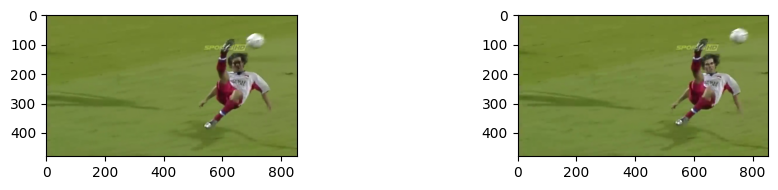

In [3]:
# frame1, frame2 = get_two_consecutive_frames("dane/kick.mp4", 12)
frame1, frame2 = get_two_consecutive_frames("dane/kick.mp4", 36)
plot_frames(frame1, frame2)

In [13]:
def get_optical_flow(
    frame_prev: np.ndarray,
    frame_curr: np.ndarray,
    pyr_scale: float,
    levels: int,
    winsize: int,
    iterations: int,
    poly_n: int,
    poly_sigma: float,
    flags: int,
):
    hsv = np.zeros_like(frame_prev)
    hsv[..., 1] = 255
    frame_prev_gray = cv2.cvtColor(frame_prev, cv2.COLOR_BGR2GRAY)
    frame_curr_gray = cv2.cvtColor(frame_curr, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        frame_prev_gray,
        frame_curr_gray,
        # np.zeros_like(frame_prev_gray),
        None,
        pyr_scale,
        levels,
        winsize,
        iterations,
        poly_n,
        poly_sigma,
        flags,
    )
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, np.zeros_like(mag), 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

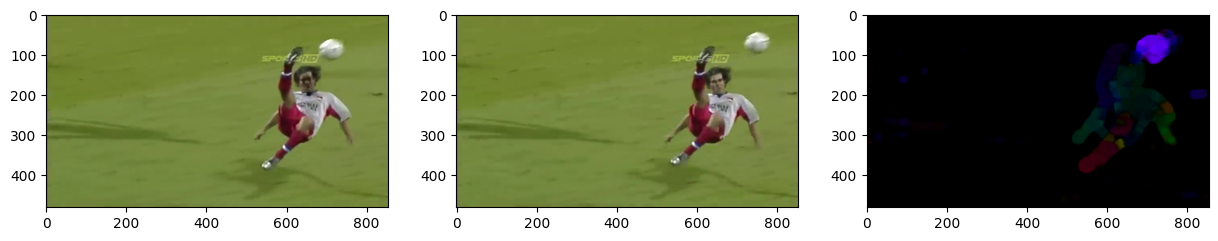

In [14]:
optical_flow = get_optical_flow(frame1, frame2, 0.5, 3, 15, 3, 5, 1.2, 0)
plot_frames_and_flow(frame1, frame2, optical_flow)

![](./hsv%20hue.png)


#### Zadanie 1b

Zbadaj wpływ parametru `winsize` na działanie metody.


From [documentation](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af)

> - winsize - averaging window size; larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.


win_size=1


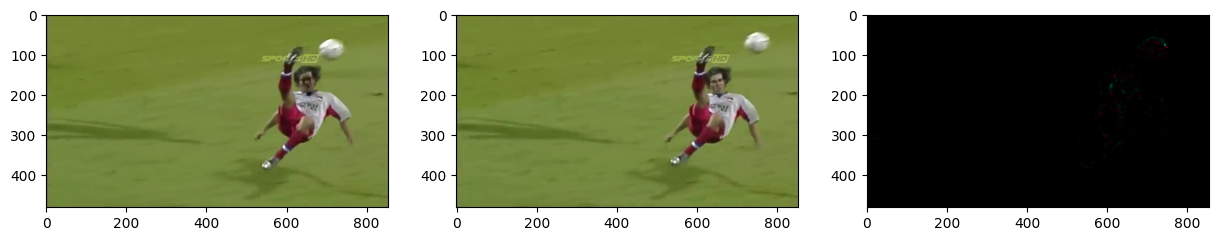

win_size=2


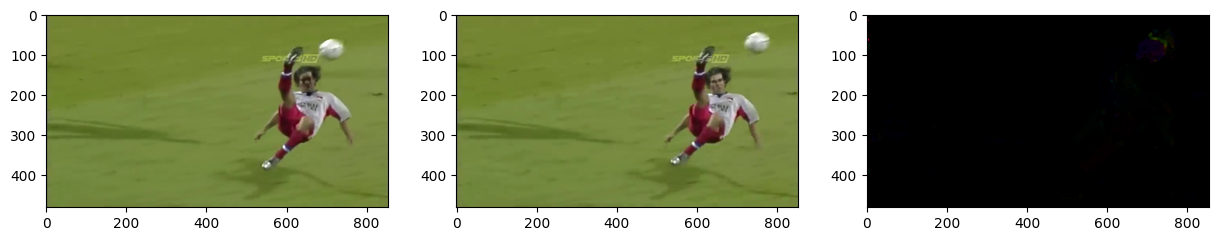

win_size=5


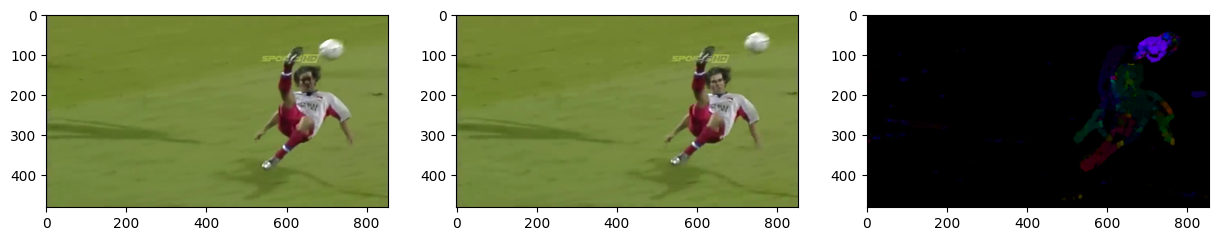

win_size=10


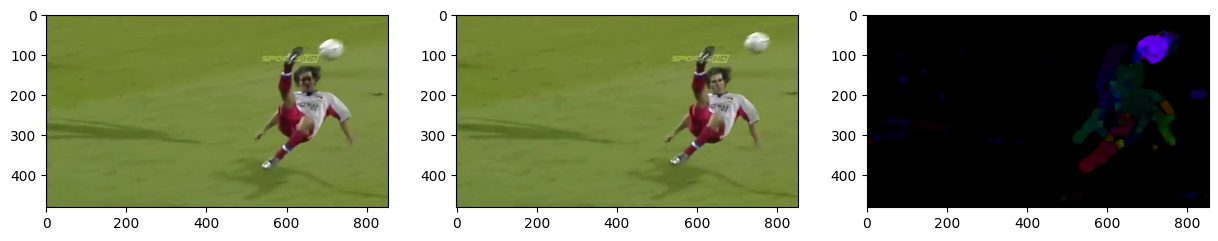

win_size=50


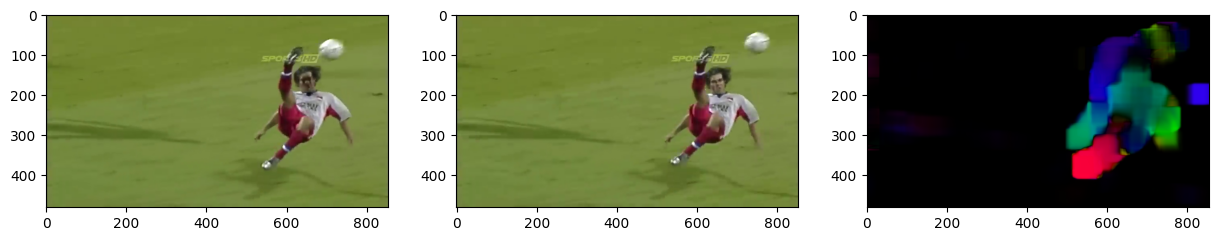

win_size=100


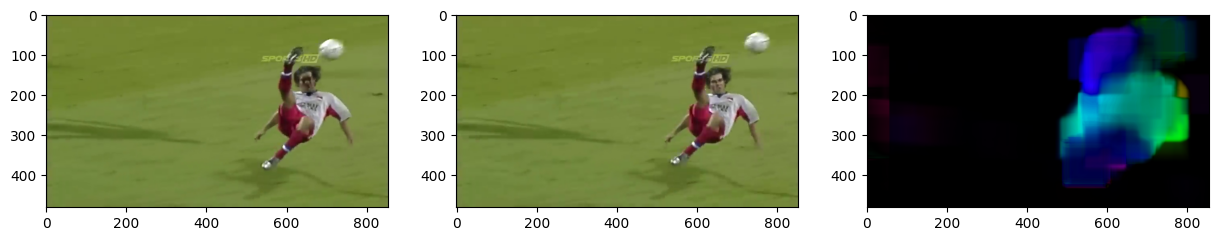

win_size=1000


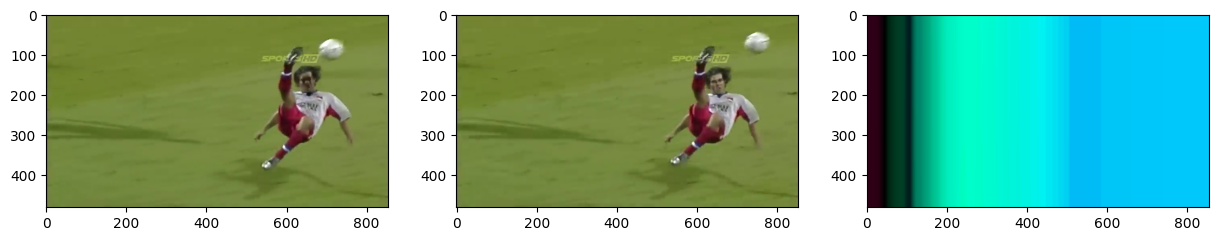

In [15]:
frame1, frame2 = get_two_consecutive_frames("dane/kick.mp4", 36)
win_sizes = [1, 2, 5, 10, 50, 100, 1000]
for win_size in win_sizes:
    print(f"{win_size=}")
    optical_flow = get_optical_flow(frame1, frame2, 0.5, 3, win_size, 3, 5, 1.2, 0)
    plot_frames_and_flow(frame1, frame2, optical_flow)

Komentarz 1:

...


---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
_Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?_


win_size=1


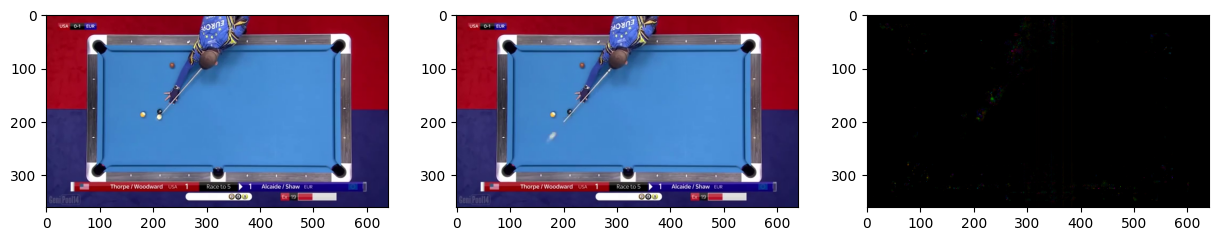

win_size=2


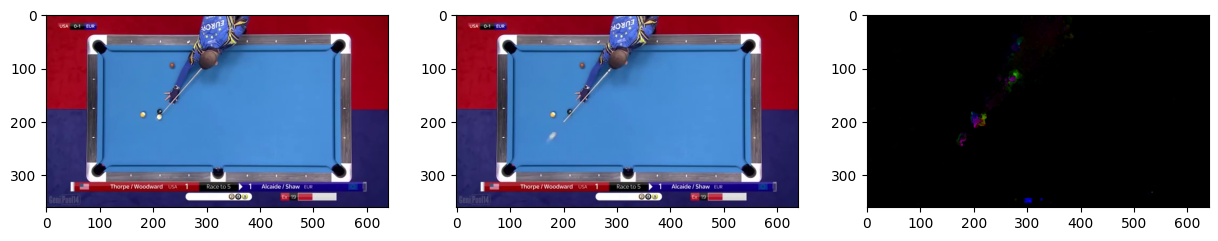

win_size=3


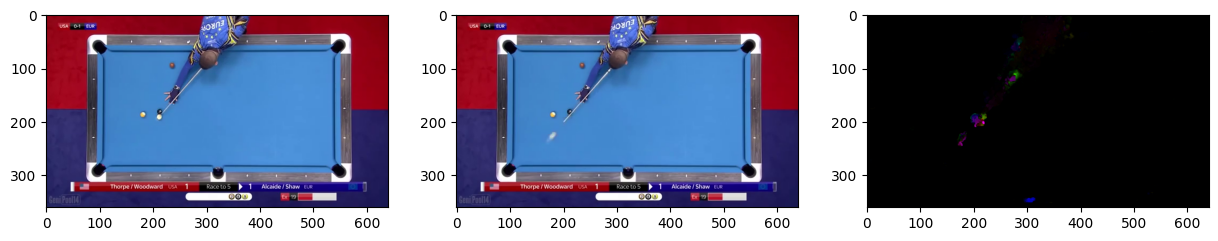

win_size=4


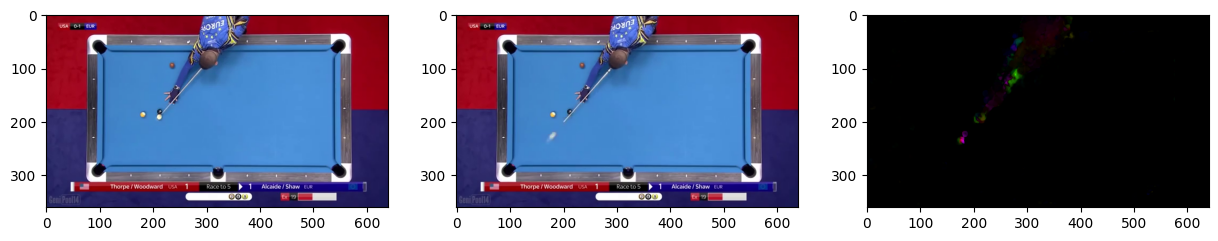

win_size=5


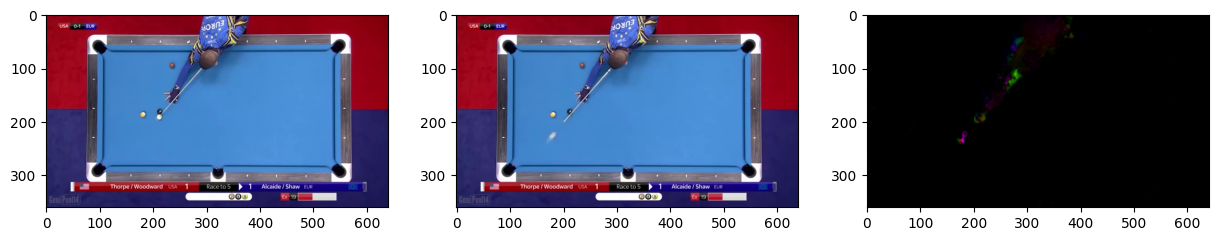

win_size=10


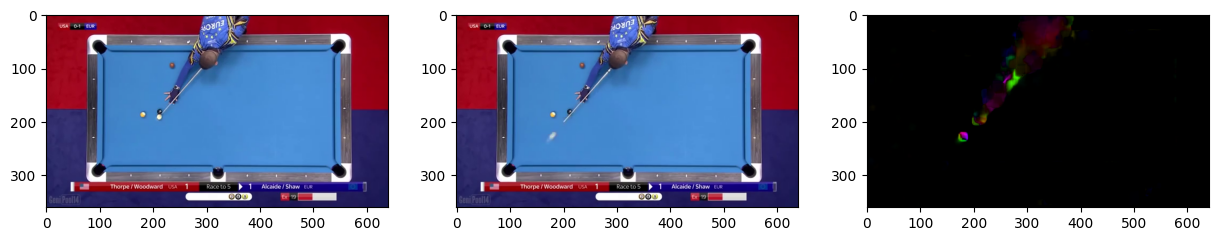

win_size=100


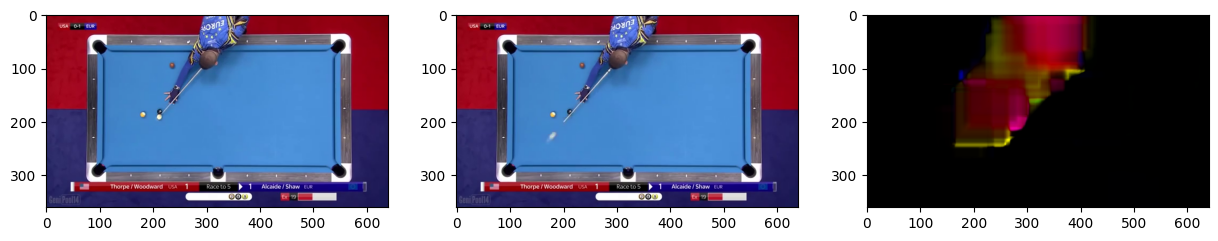

In [16]:
frame1, frame2 = get_two_consecutive_frames("dane/shot.mp4", 21)
win_sizes = [1, 2, 3, 4, 5, 10, 100]
for win_size in win_sizes:
    print(f"{win_size=}")
    optical_flow = get_optical_flow(frame1, frame2, 0.5, 3, win_size, 3, 5, 1.2, 0)
    plot_frames_and_flow(frame1, frame2, optical_flow)

win_size=1


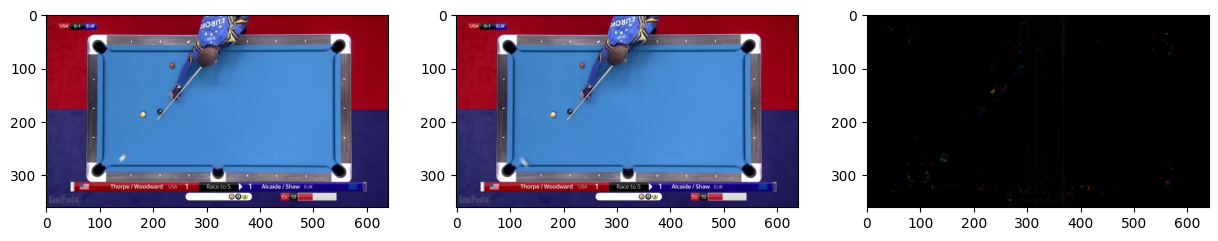

win_size=2


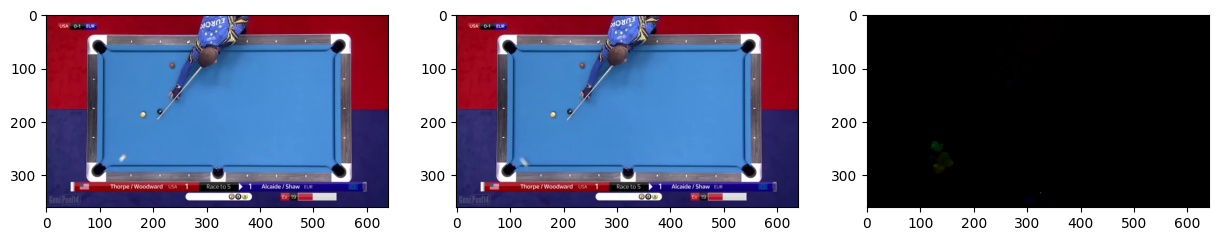

win_size=3


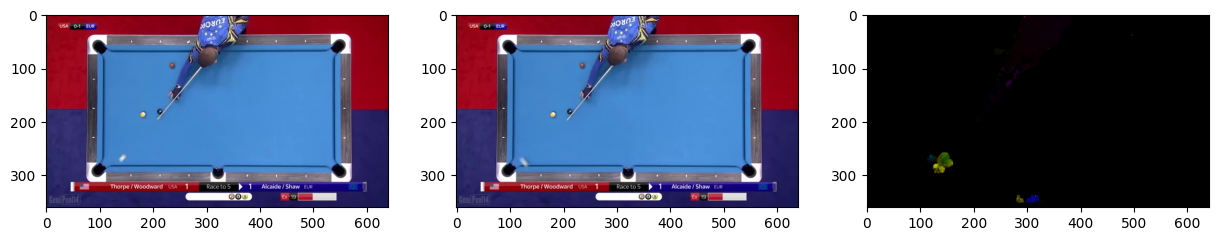

win_size=4


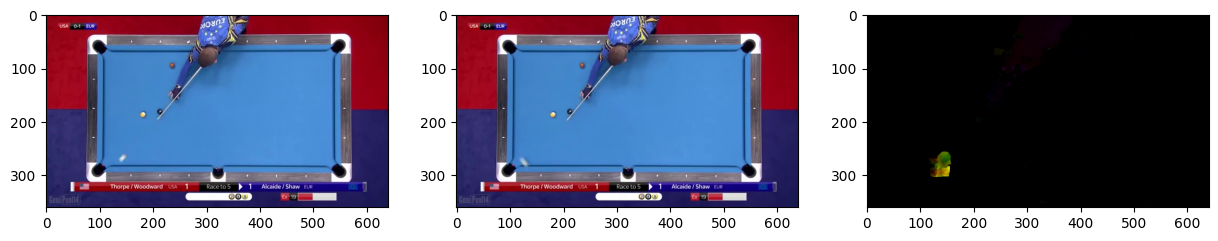

win_size=5


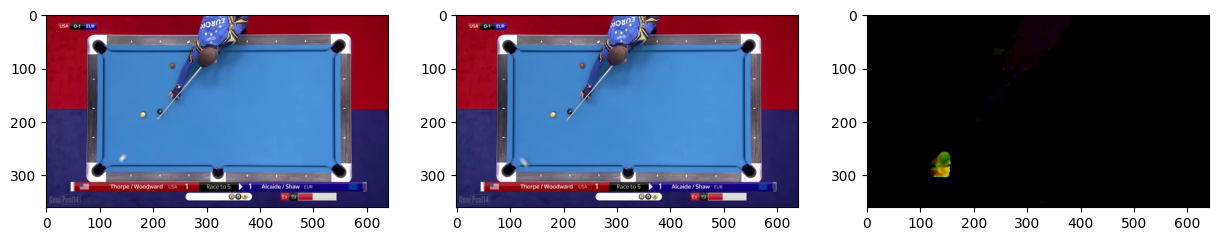

win_size=6


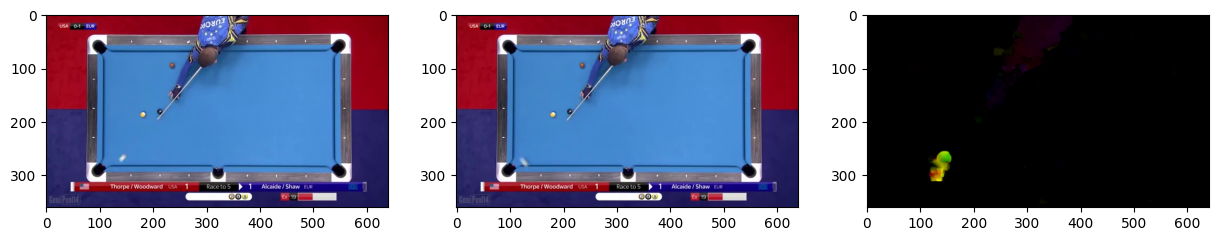

win_size=7


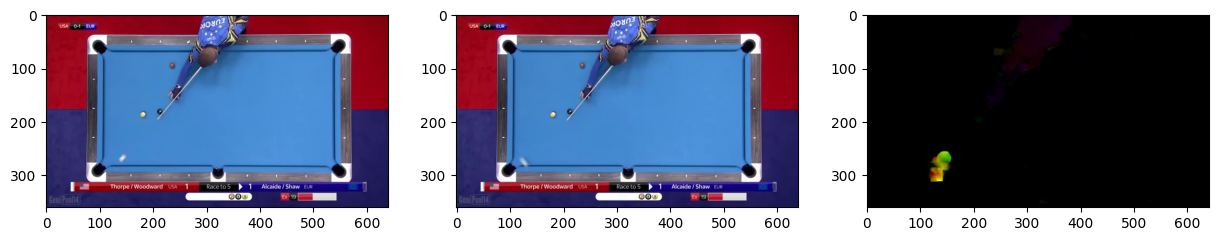

win_size=8


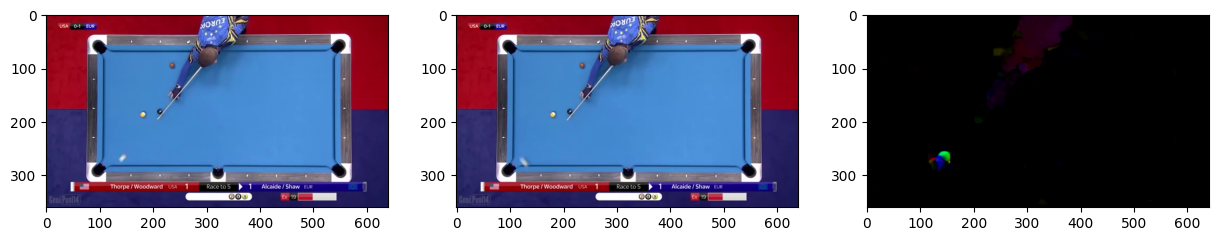

win_size=10


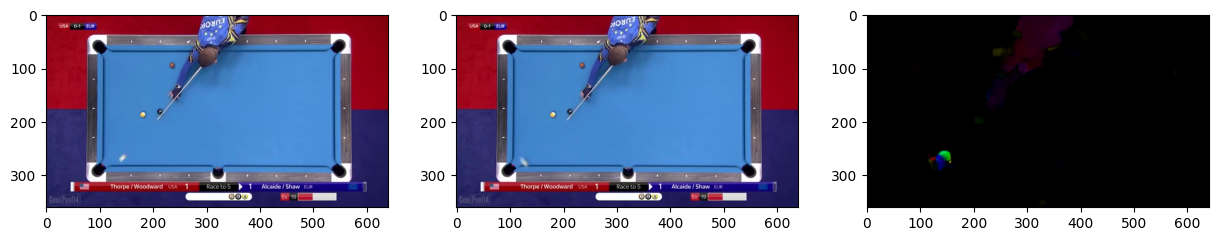

In [17]:
frame1, frame2 = get_two_consecutive_frames("dane/shot.mp4", 23)
win_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 10]
for win_size in win_sizes:
    print(f"{win_size=}")
    optical_flow = get_optical_flow(frame1, frame2, 0.5, 3, win_size, 3, 5, 1.2, 0)
    plot_frames_and_flow(frame1, frame2, optical_flow)

Komentarz 2:

- dla klatek 21-22 działa dobrze dla win_size=3,4
- dla klatek 23-24 gorzej - widać dla win_size=3, ale rozmazane - piłka zbyt szybko się porusza co powoduje, że mocno zmienia kształt (nie ma spełnionego wymagania niezmienności obiektu między klatkami)
  ...


### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).


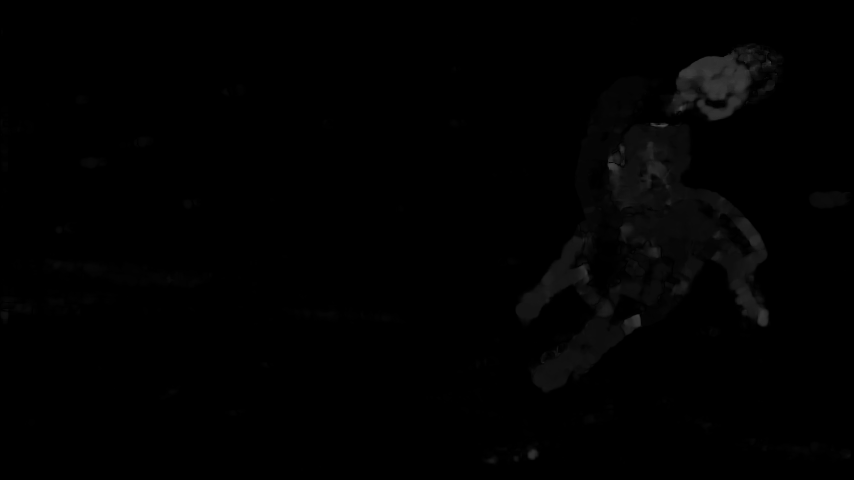

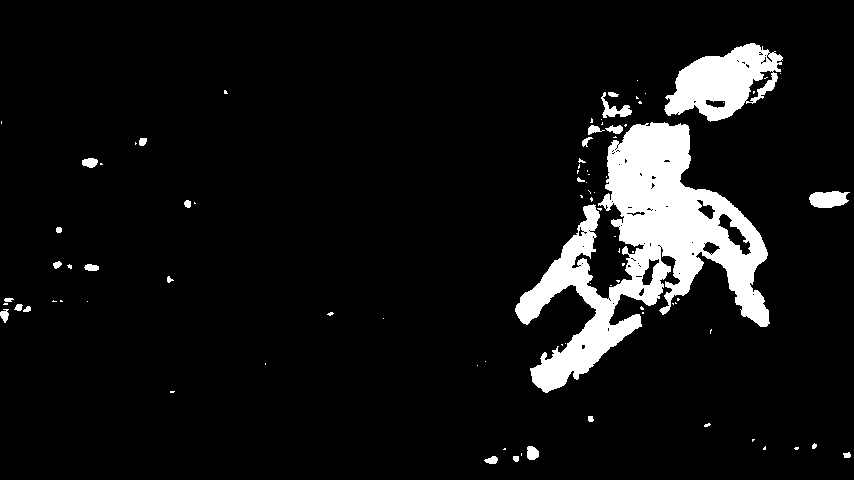

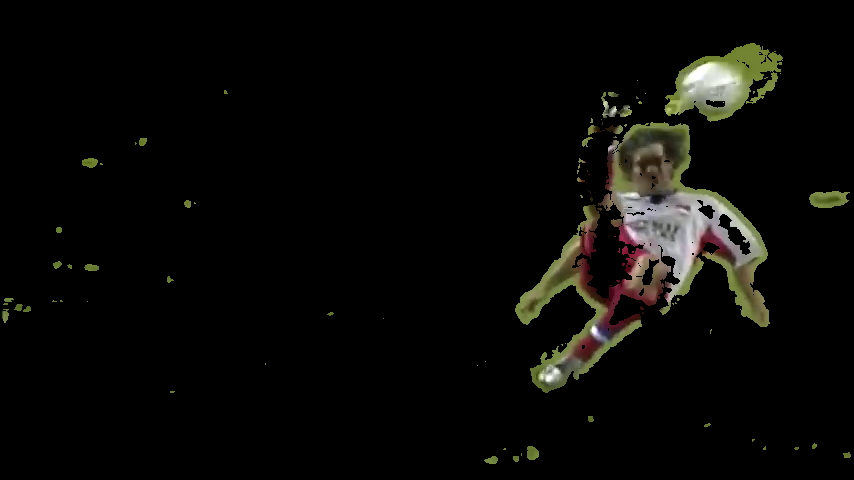

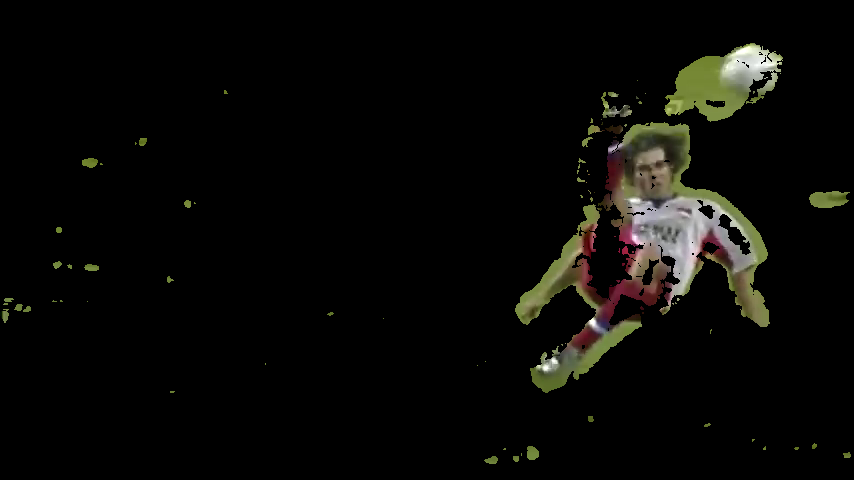

In [18]:
from zipfile import ZIP_BZIP2


frame1, frame2 = get_two_consecutive_frames("dane/kick.mp4", 36)
win_size = 5
optical_flow = get_optical_flow(frame1, frame2, 0.5, 3, win_size, 3, 5, 1.2, 0)

optical_flow_gray = cv2.cvtColor(optical_flow, cv2.COLOR_RGB2GRAY)
display(to_pil_image(optical_flow_gray))

ret, mask = cv2.threshold(optical_flow_gray, 5, 1, cv2.THRESH_BINARY)
display(to_pil_image(mask * 255))

frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
mask_3_channel = np.stack((mask, mask, mask), axis=-1)
frame1_thresh = frame1_rgb * mask_3_channel
display(to_pil_image(frame1_thresh))
# display(to_pil_image(frame1_rgb))

frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame2_thresh = frame2_rgb * mask_3_channel
display(to_pil_image(frame2_thresh))